## Reference:
- https://learn.deeplearning.ai/courses/quantization-in-depth/

# Overview - Linear Quantization 
- This notebook shows how to perform Linear Quantization. It goes over:  
    - Symmetric & Asymmetric modes
    - Calculate Scale and Zero Point
    - Perform Linear quantization
    - Perform dequantization
    - Measure & Plot quantization errors
    - Different granularities of quantization
        - Per tensor
        - Per channel
        - Per group

# Functions
- Perform linear quantization given scale, zero point
- Calcuate / Plot quantization errors

In [1]:
import torch

In [2]:
# Quantization function
def linear_q_with_scale_and_zero_point(tensor, scale, zero_point, dtype = torch.int8):
    scaled_and_shifted_tensor = tensor / scale + zero_point
    rounded_tensor = torch.round(scaled_and_shifted_tensor)
    q_min = torch.iinfo(dtype).min
    q_max = torch.iinfo(dtype).max
    q_tensor = rounded_tensor.clamp(q_min,q_max).to(dtype)    
    return q_tensor

# Dequantization function
def linear_dequantization(quantized_tensor, scale, zero_point):
    return scale * (quantized_tensor.float() - zero_point)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_matrix(tensor, ax, title, vmin=0, vmax=1, cmap=None):
    """
    Plot a heatmap of tensors using seaborn
    """
    sns.heatmap(tensor.cpu().numpy(), ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, annot=True, fmt=".2f", cbar=False)
    ax.set_title(title)
    ax.set_yticklabels([])
    ax.set_xticklabels([])


def plot_quantization_errors(original_tensor, quantized_tensor, dequantized_tensor, dtype = torch.int8, n_bits = 8):
    """
    A method that plots 4 matrices, the original tensor, the quantized tensor
    the de-quantized tensor and the error tensor.
    """
    # Get a figure of 4 plots
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))

    # Plot the first matrix
    plot_matrix(original_tensor, axes[0], 'Original Tensor', cmap=ListedColormap(['white']))

    # Get the quantization range and plot the quantized tensor
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    plot_matrix(quantized_tensor, axes[1], f'{n_bits}-bit Linear Quantized Tensor', vmin=q_min, vmax=q_max, cmap='coolwarm')

    # Plot the de-quantized tensors
    plot_matrix(dequantized_tensor, axes[2], 'Dequantized Tensor', cmap='coolwarm')

    # Get the quantization errors
    q_error_tensor = abs(original_tensor - dequantized_tensor)
    plot_matrix(q_error_tensor, axes[3], 'Quantization Error Tensor', cmap=ListedColormap(['white']))

    fig.tight_layout()
    plt.show()
    
def quantization_error(tensor, dequantized_tensor):
    return (dequantized_tensor - tensor).abs().square().mean()

## Finding `Scale` and `Zero Point` for Quantization

In [4]:
### a dummy tensor to test the implementation
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)

In [5]:
q_min = torch.iinfo(torch.int8).min
q_max = torch.iinfo(torch.int8).max
q_min, q_max

(-128, 127)

In [6]:
# r_min = test_tensor.min()
r_min = test_tensor.min().item()
r_max = test_tensor.max().item()
r_min, r_max

(-184.0, 728.5999755859375)

In [7]:
scale = (r_max - r_min) / (q_max - q_min)
scale

3.578823433670343

In [8]:
zero_point = q_min - (r_min / scale)
print(zero_point)
zero_point = int(round(zero_point))
print(zero_point)

-76.58645490333825
-77


In [9]:
# Put the above in a function
def get_q_scale_and_zero_point(tensor, dtype=torch.int8):
    
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    r_min, r_max = tensor.min().item(), tensor.max().item()

    scale = (r_max - r_min) / (q_max - q_min)

    zero_point = q_min - (r_min / scale)

    # clip the zero_point to fall in [quantized_min, quantized_max]
    if zero_point < q_min:
        zero_point = q_min
    elif zero_point > q_max:
        zero_point = q_max
    else:
        # round and cast to int
        zero_point = int(round(zero_point))
    
    return scale, zero_point

In [10]:
new_scale, new_zero_point = get_q_scale_and_zero_point(test_tensor)
new_scale, new_zero_point 

(3.578823433670343, -77)

## Quantization and Dequantization with calcuated `Scale` and `Zero Point`

In [11]:
test_tensor

tensor([[ 191.6000,  -13.5000,  728.6000],
        [  92.1400,  295.5000, -184.0000],
        [   0.0000,  684.6000,  245.5000]])

In [12]:
quantized_tensor = linear_q_with_scale_and_zero_point(test_tensor, 
                                                      new_scale, new_zero_point)
quantized_tensor

tensor([[ -23,  -81,  127],
        [ -51,    6, -128],
        [ -77,  114,   -8]], dtype=torch.int8)

In [13]:
dequantized_tensor = linear_dequantization(quantized_tensor,
                                           new_scale, new_zero_point)
dequantized_tensor

tensor([[ 193.2565,  -14.3153,  730.0800],
        [  93.0494,  297.0423, -182.5200],
        [   0.0000,  683.5552,  246.9388]])

In [14]:
# Dequantize without casting quantized_tensor to float() - not accurate
new_scale * (quantized_tensor - new_zero_point)

tensor([[ 193.2565,  -14.3153, -186.0988],
        [  93.0494,  297.0423, -182.5200],
        [   0.0000, -232.6235,  246.9388]])

- Calculate & Plot Quantization Error

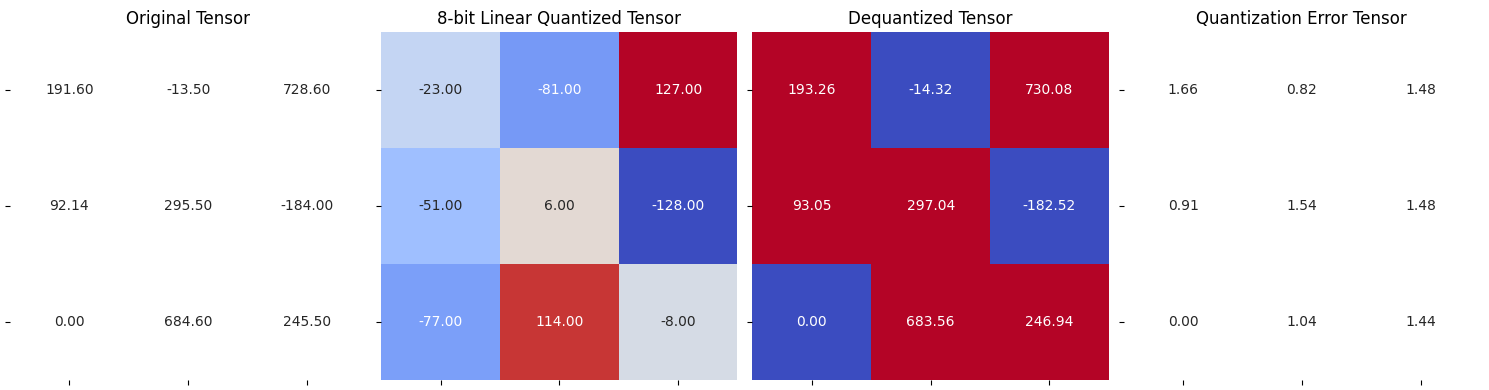

In [15]:
plot_quantization_errors(test_tensor, quantized_tensor, 
                         dequantized_tensor)

In [16]:
(dequantized_tensor-test_tensor).square().mean()

tensor(1.5730)

## Final Linear Quantizer

In [17]:
def linear_quantization(tensor, dtype=torch.int8):
    scale, zero_point = get_q_scale_and_zero_point(tensor, 
                                                   dtype=dtype)
    
    quantized_tensor = linear_q_with_scale_and_zero_point(tensor,
                                                          scale, 
                                                          zero_point, 
                                                          dtype=dtype)
    
    return quantized_tensor, scale , zero_point

In [18]:
r_tensor = torch.randn((4, 4))
r_tensor

tensor([[ 0.7234,  0.9598, -1.7701,  1.2832],
        [ 0.4508, -0.9940, -0.7507,  0.1552],
        [ 0.9640, -0.2588, -0.4298,  0.5021],
        [-0.0831,  0.0830, -0.0699,  0.3569]])

In [19]:
quantized_tensor, scale, zero_point = linear_quantization(r_tensor)
quantized_tensor, scale, zero_point

(tensor([[  80,  100, -128,  127],
         [  58,  -63,  -43,   33],
         [ 101,   -2,  -16,   62],
         [  13,   27,   14,   50]], dtype=torch.int8),
 0.011973848997377882,
 20)

In [20]:
dequantized_tensor = linear_dequantization(quantized_tensor,scale, zero_point)

- Calculate & Plot Quantization Error

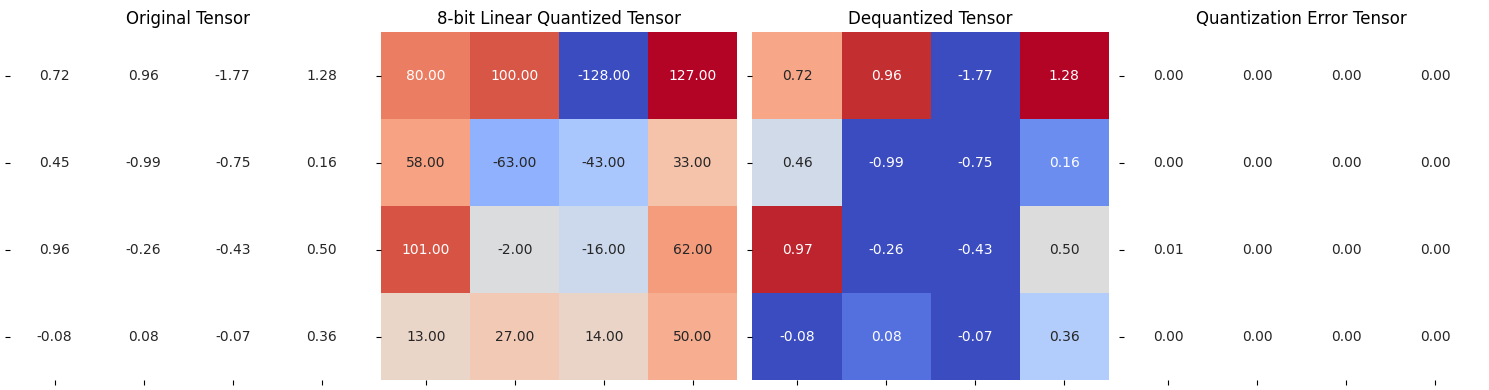

In [21]:
plot_quantization_errors(r_tensor, quantized_tensor,dequantized_tensor)

In [22]:
(dequantized_tensor-r_tensor).square().mean()

tensor(8.4872e-06)

# Symmetric mode
- In symmetric mode:
    - Only the max of the tensor is used (min is not considered)
    - Zero point is set to 0

In [23]:
def get_q_scale_symmetric(tensor, dtype=torch.int8):
    r_max = tensor.abs().max().item()
    q_max = torch.iinfo(dtype).max

    # return the scale
    return r_max/q_max

In [24]:
test_tensor = r_tensor

In [25]:
get_q_scale_symmetric(test_tensor)

0.013937979232607863

In [26]:
def linear_q_symmetric(tensor, dtype=torch.int8):
    scale = get_q_scale_symmetric(tensor)
    
    quantized_tensor = linear_q_with_scale_and_zero_point(tensor,
                                                     scale=scale,
                   # in symmetric quantization zero point is = 0    
                                                    zero_point=0,
                                                      dtype=dtype)
    
    return quantized_tensor, scale

In [27]:
quantized_tensor, scale = linear_q_symmetric(test_tensor)

In [28]:
dequantized_tensor = linear_dequantization(quantized_tensor,scale,0)

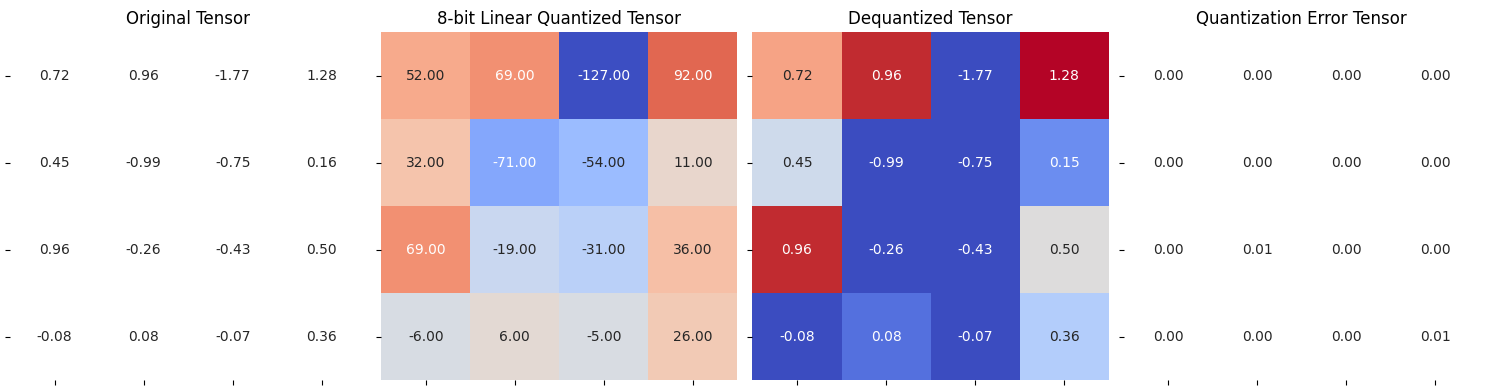

In [29]:
plot_quantization_errors(
    test_tensor, quantized_tensor, dequantized_tensor)

In [30]:
print(f"""Quantization Error : \
{quantization_error(test_tensor, dequantized_tensor)}""")

Quantization Error : 8.392506060772575e-06


## Different Granularities for Quantization
- For simplicity, you'll perform these using Symmetric mode.

In [31]:
# test tensor
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)
test_tensor, test_tensor.shape

(tensor([[ 191.6000,  -13.5000,  728.6000],
         [  92.1400,  295.5000, -184.0000],
         [   0.0000,  684.6000,  245.5000]]),
 torch.Size([3, 3]))

### Per tensor

In [32]:
quantized_tensor, scale = linear_q_symmetric(test_tensor)

In [33]:
dequantized_tensor = linear_dequantization(quantized_tensor, scale, 0)

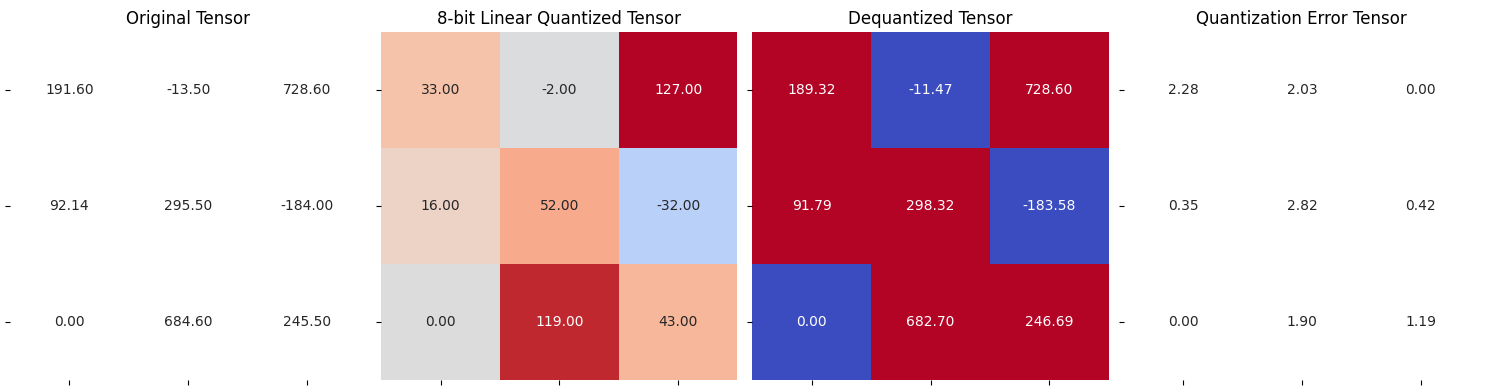

In [34]:
plot_quantization_errors(test_tensor, 
                         quantized_tensor, dequantized_tensor)

In [35]:
print(f"""Quantization Error : \
{quantization_error(test_tensor, dequantized_tensor)}""")

Quantization Error : 2.5091912746429443


### Per channel

In [36]:
# Example of division

m = torch.tensor([[1,2,3],[4,5,6],[7,8,9]])
print(m, m.shape)

# along row
scale = torch.tensor([[1], [5], [10]])
print(scale, scale.shape)
m_scaled = m/scale
print(m_scaled, m_scaled.shape)

# along column
scale = torch.tensor([1,5,10])
print(scale, scale.shape)
m_scaled = m/scale
print(m_scaled, m_scaled.shape)

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]]) torch.Size([3, 3])
tensor([[ 1],
        [ 5],
        [10]]) torch.Size([3, 1])
tensor([[1.0000, 2.0000, 3.0000],
        [0.8000, 1.0000, 1.2000],
        [0.7000, 0.8000, 0.9000]]) torch.Size([3, 3])
tensor([ 1,  5, 10]) torch.Size([3])
tensor([[1.0000, 0.4000, 0.3000],
        [4.0000, 1.0000, 0.6000],
        [7.0000, 1.6000, 0.9000]]) torch.Size([3, 3])


In [37]:
# Check select function
print(test_tensor, test_tensor.shape)

# Select row ix1
print(test_tensor[1])
print(test_tensor.select(0, 1))

# Select col ix1
print(test_tensor[:,1])
print(test_tensor.select(1, 1))

tensor([[ 191.6000,  -13.5000,  728.6000],
        [  92.1400,  295.5000, -184.0000],
        [   0.0000,  684.6000,  245.5000]]) torch.Size([3, 3])
tensor([  92.1400,  295.5000, -184.0000])
tensor([  92.1400,  295.5000, -184.0000])
tensor([-13.5000, 295.5000, 684.6000])
tensor([-13.5000, 295.5000, 684.6000])


In [38]:
def linear_q_symmetric_per_channel(r_tensor, dim, dtype=torch.int8):
    
    output_dim = r_tensor.shape[dim]
    
    # Iterate through each row
    # store the scales
    scale = torch.zeros(output_dim)
    for index in range(output_dim):
        sub_tensor = r_tensor.select(dim, index)
        scale[index] = get_q_scale_symmetric(sub_tensor, dtype=dtype)
    # reshape the scale
    scale_shape = [1] * r_tensor.dim()
    scale_shape[dim] = -1
    scale = scale.view(scale_shape)
    
    quantized_tensor = linear_q_with_scale_and_zero_point(
        r_tensor, scale=scale, zero_point=0, dtype=dtype)
   
    return quantized_tensor, scale

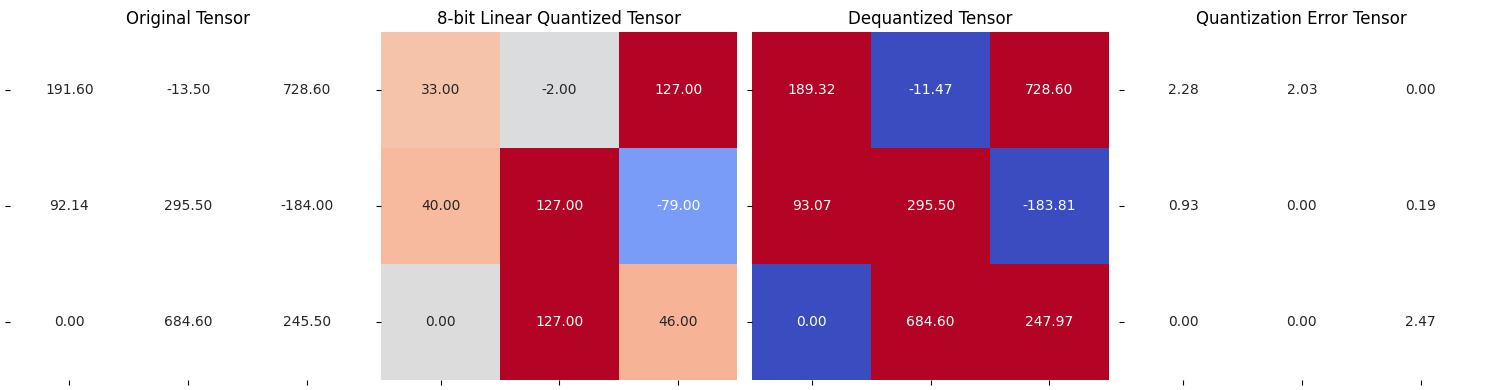

Quantization Error : 1.8084441423416138


In [39]:
### along the rows (dim = 0)
quantized_tensor_0, scale_0 = linear_q_symmetric_per_channel(test_tensor, dim=0)

dequantized_tensor_0 = linear_dequantization(quantized_tensor_0, scale_0, 0)

plot_quantization_errors(test_tensor, 
                         quantized_tensor_0, dequantized_tensor_0)

print(f"""Quantization Error : \
{quantization_error(test_tensor, dequantized_tensor_0)}""")

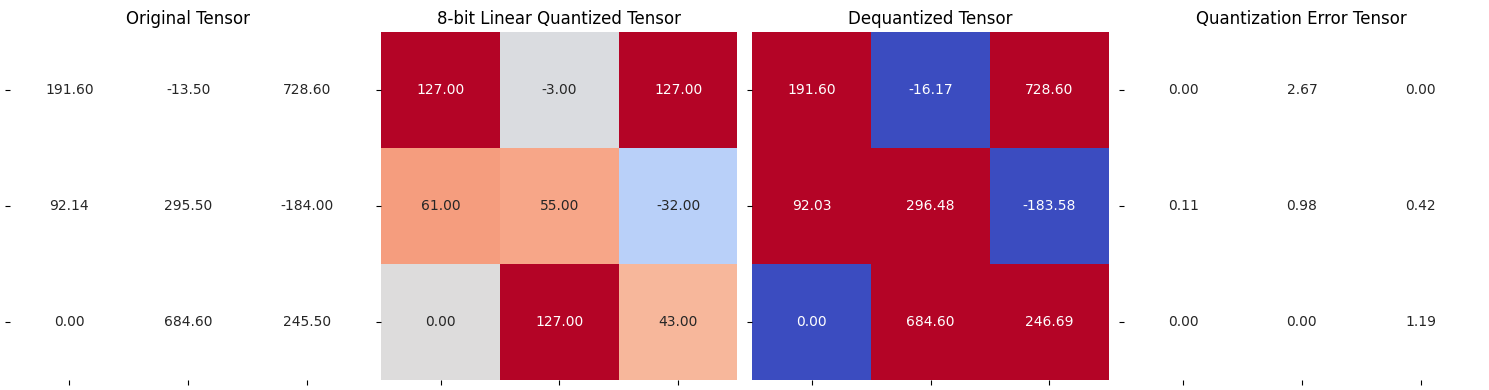

Quantization Error : 1.0781488418579102


In [40]:
### along the columns (dim = 1)
quantized_tensor_1, scale_1 = linear_q_symmetric_per_channel(test_tensor, dim=1)

dequantized_tensor_1 = linear_dequantization(quantized_tensor_1, scale_1, 0)

plot_quantization_errors(test_tensor, 
                         quantized_tensor_1, dequantized_tensor_1, n_bits=8)

print(f"""Quantization Error : \
{quantization_error(test_tensor, dequantized_tensor_1)}""")

### Per group

In [41]:
def linear_q_symmetric_per_group(tensor, group_size,
                                 dtype=torch.int8):
    
    t_shape = tensor.shape
    assert t_shape[1] % group_size == 0
    assert tensor.dim() == 2
    
    tensor = tensor.view(-1, group_size)
    
    quantized_tensor, scale = linear_q_symmetric_per_channel(
                                tensor, dim=0, dtype=dtype)
    
    quantized_tensor = quantized_tensor.view(t_shape)
    
    return quantized_tensor, scale

def linear_dequantization_per_group(quantized_tensor, scale, 
                                    group_size):
    
    q_shape = quantized_tensor.shape
    quantized_tensor = quantized_tensor.view(-1, group_size)
    
    dequantized_tensor = linear_dequantization(quantized_tensor, 
                                               scale, 0)
    
    dequantized_tensor = dequantized_tensor.view(q_shape)
    
    return dequantized_tensor

In [42]:
test_tensor = torch.rand((6, 6))
test_tensor

tensor([[0.2412, 0.4575, 0.7266, 0.1361, 0.0817, 0.3144],
        [0.7280, 0.3506, 0.5309, 0.3154, 0.2129, 0.0584],
        [0.6542, 0.3721, 0.4735, 0.9058, 0.1570, 0.5638],
        [0.0864, 0.0393, 0.6803, 0.1631, 0.5140, 0.0342],
        [0.3863, 0.9314, 0.7040, 0.1297, 0.0515, 0.2377],
        [0.4805, 0.1059, 0.5007, 0.5464, 0.1840, 0.0364]])

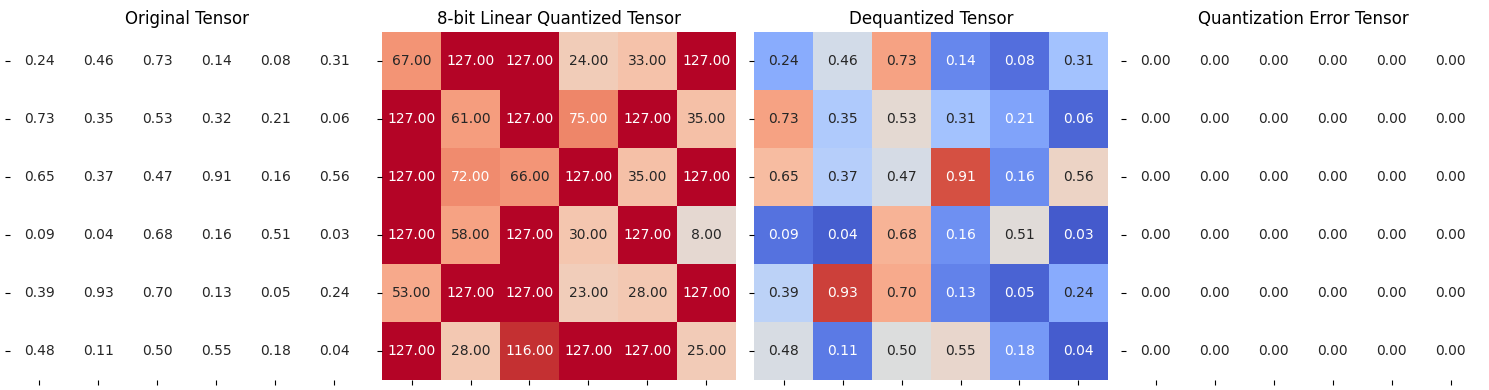

Quantization Error : 1.1453657862148248e-06


In [43]:
group_size = 2

quantized_tensor, scale = linear_q_symmetric_per_group(test_tensor,
                                                       group_size=group_size)

dequantized_tensor = linear_dequantization_per_group(quantized_tensor, 
                                                     scale, group_size=group_size)

plot_quantization_errors(test_tensor, 
                         quantized_tensor, dequantized_tensor)

print(f"""Quantization Error : \
{quantization_error(test_tensor, dequantized_tensor)}""")